<a href="https://colab.research.google.com/github/ctorney/learning-to-simulate-tf2/blob/main/test-files/VelocitySpektralModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral

In [103]:
#@title ### Imports { form-width: "30%" }

import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc

import tensorflow as tf

from scipy import stats

import pickle

import functools
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from spektral.layers import ECCConv, GlobalAvgPool, MessagePassing, XENetConv, GlobalAttentionPool, GlobalMaxPool, GlobalSumPool,GlobalAttnSumPool


plt.style.use('ggplot')
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid')

# Generate Data

In [3]:
#@title ### Zonal Model { form-width: "30%" }

def get_record(group_id,pos,vel,acc):
    feature = { 'group_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[group_id])),
                'pos': tf.train.Feature(bytes_list=tf.train.BytesList(value=[pos.numpy()])),
                'vel': tf.train.Feature(bytes_list=tf.train.BytesList(value=[vel.numpy()])),
                'acc': tf.train.Feature(bytes_list=tf.train.BytesList(value=[acc.numpy()]))
                }
    return tf.train.Example(features=tf.train.Features(feature=feature))


class zonal_model:
    def __init__(self, N, timesteps, discard, repeat, L, dt, save_interval,train_directory='train_datasets', valid_directory='valid_datasets', disable_progress=False):
        self.N = N
        self.timesteps = timesteps
        self.discard = discard
        self.B = repeat  # repeat for B batches
        self.L = L
        self.dt = dt
        self.save_interval = save_interval
        
        self.micro_state = np.zeros((self.B, (self.timesteps - self.discard)//self.save_interval, N, 4),dtype=np.float32)

        self.sim_counter=0

        if not os.path.exists(train_directory):
            os.makedirs(train_directory)

        if not os.path.exists(valid_directory):
            os.makedirs(valid_directory)

        self.train_directory = train_directory
        self.valid_directory = valid_directory

        # turn progress bar on or off
        self.disable_progress = disable_progress

        self.valid_fraction = 0.1
        
    def initialise_state(self):

        #self.positions = tf.random.uniform((self.B,self.N,2),0.5*self.L, 0.5*self.L+20) #0,self.L)
        self.positions = tf.random.uniform((self.B,self.N,2),0, self.L) 
        self.angles = tf.random.uniform((self.B,self.N,1), 0, 2*pi) #
        


    def run_sim(self, *params):

        eta, Ra, Ro, Rr, vs, va, sigma = params
        
        record_file = self.train_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.writer = tf.io.TFRecordWriter(record_file) 
        
        valid_file = self.valid_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.validwriter = tf.io.TFRecordWriter(valid_file) 
        
        # tensorflow function to run an update step
        @tf.function
        def update_tf(X, A):
            cos_A = tf.math.cos(A)
            sin_A = tf.math.sin(A)


            Xx = tf.expand_dims(X[...,0],-1)
            dx = -Xx + tf.linalg.matrix_transpose(Xx)
            dx = tf.where(dx>0.5*self.L, dx-self.L, dx)
            dx = tf.where(dx<-0.5*self.L, dx+self.L, dx)

            Xy = tf.expand_dims(X[...,1],-1)
            dy = -Xy + tf.linalg.matrix_transpose(Xy)
            dy = tf.where(dy>0.5*self.L, dy-self.L, dy)
            dy = tf.where(dy<-0.5*self.L, dy+self.L, dy)


            angle_to_neigh = tf.math.atan2(dy, dx)
            cos_N = tf.math.cos(angle_to_neigh)
            sin_N = tf.math.sin(angle_to_neigh)
            rel_angle_to_neigh = angle_to_neigh - A
            rel_angle_to_neigh = tf.math.atan2(tf.math.sin(rel_angle_to_neigh), tf.math.cos(rel_angle_to_neigh))
            
            dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))
    
            # repulsion 
            rep_x = tf.where(dist<=Rr, -dx, tf.zeros_like(dx))
            rep_x = tf.where(rel_angle_to_neigh<0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.where(rel_angle_to_neigh>-0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.math.divide_no_nan(rep_x,tf.math.square(dist))
            rep_x = tf.reduce_sum(rep_x,axis=2)

            rep_y = tf.where(dist<=Rr, -dy, tf.zeros_like(dy))
            rep_y = tf.where(rel_angle_to_neigh<0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.where(rel_angle_to_neigh>-0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.math.divide_no_nan(rep_y,tf.math.square(dist))
            rep_y = tf.reduce_sum(rep_y,axis=2)

            # alignment 
            align_x = tf.where(dist<=Ro, cos_A, tf.zeros_like(cos_A))
            align_x = tf.where(rel_angle_to_neigh<0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.where(rel_angle_to_neigh>-0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.reduce_sum(align_x,axis=1)
            
            align_y = tf.where(dist<=Ro, sin_A, tf.zeros_like(sin_A))
            align_y = tf.where(rel_angle_to_neigh<0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.where(rel_angle_to_neigh>-0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.reduce_sum(align_y,axis=1)

            al_norm = tf.math.sqrt(align_x**2+align_y**2)
            align_x = tf.math.divide_no_nan(align_x,al_norm)
            align_y = tf.math.divide_no_nan(align_y,al_norm)

            # attractive interactions
            attr_x = tf.where(dist<=Ra, dx, tf.zeros_like(dx))
            attr_x = tf.where(rel_angle_to_neigh<0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.where(rel_angle_to_neigh>-0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.reduce_sum(attr_x,axis=2)

            attr_y = tf.where(dist<=Ra, dy, tf.zeros_like(dy))
            attr_y = tf.where(rel_angle_to_neigh<0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.where(rel_angle_to_neigh>-0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.reduce_sum(attr_y,axis=2)

            at_norm = tf.math.sqrt(attr_x**2+attr_y**2)
            attr_x = tf.math.divide_no_nan(attr_x,at_norm)
            attr_y = tf.math.divide_no_nan(attr_y,at_norm)

            # combine angles and convert to desired angle change
            social_x = rep_x + align_x + attr_x
            social_y = rep_y + align_y + attr_y

            d_angle = tf.math.atan2(social_y,social_x)
            d_angle = tf.expand_dims(d_angle,-1)

            
            d_angle = tf.math.atan2((1-eta)*tf.math.sin(d_angle) + eta*sin_A, (1-eta)*tf.math.cos(d_angle) + eta*cos_A)

            d_angle = d_angle - A
            d_angle = tf.where(d_angle>pi, d_angle-2*pi, d_angle)
            d_angle = tf.where(d_angle<-pi, d_angle+2*pi, d_angle)


            # add perception noise
            noise = tf.random.normal(shape=(self.B,self.N,1),mean=0,stddev=sigma*(self.dt**0.5))
            d_angle = d_angle + noise
            
            # restrict to maximum turning angle
            #d_angle = tf.where(tf.math.abs(d_angle)>eta*self.dt, tf.math.sign(d_angle)*eta*self.dt, d_angle)
            
            # rotate headings
            A = A + d_angle
            
            # update positions
            velocity = self.dt*vs*tf.concat([tf.cos(A),tf.sin(A)],axis=-1)
            X += velocity

            # add periodic boundary conditions
            A = tf.where(A<-pi,  A+2*pi, A)
            A = tf.where(A>pi, A-2*pi, A)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            return X, A
            
        self.initialise_state()

        counter=0
        for i in tqdm(range(self.timesteps),disable=self.disable_progress):
            self.positions, self.angles = update_tf(self.positions,  self.angles)
            if i>=self.discard:
                if i%self.save_interval==0:
                    # store in an array in case we want to visualise
                    self.micro_state[:,counter,:,0:2] = self.positions.numpy()
                    self.micro_state[:,counter,:,2:3] = np.cos(self.angles.numpy())
                    self.micro_state[:,counter,:,3:4] = np.sin(self.angles.numpy())
                    
                        
                    

                    counter = counter + 1

        for b in range(self.B):
            self.save_tf_record(b)

        self.writer.close()
        self.validwriter.close()
        self.sim_counter+=1
        return 

    def save_tf_record(self, b):
        pos =  tf.io.serialize_tensor(self.micro_state[b,:,:,0:2])
        vel =  tf.io.serialize_tensor(self.micro_state[b,:,:,2:4])
        acc =  tf.io.serialize_tensor(np.gradient(self.micro_state[b,:,:,2:4], axis=1))

        tf_record = get_record(b,pos,vel,acc)
        if b> self.B*self.valid_fraction:
            self.writer.write(tf_record.SerializeToString())
        else:
            self.validwriter.write(tf_record.SerializeToString())

        
        return 

In [4]:
#@title ### Params { form-width: "30%" }

n_points=50 #10

param_values = np.linspace(0,25,n_points)
L= 200
N= 100 
repeat = 100
discard = 0
timesteps = 200
save_interval=1
dt=1


sim = zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval,disable_progress=False)

latt=0  # adapt
lrep= 1 # adapt
lali= 5 # adapt
eta=0.5 # adapt
va=2*pi # adapt
vs=2 # fix 
sigma=0. 

In [5]:
#@title ### Create Training Data { form-width: "30%" }

def evaluate_zonal_model(X):
    sim.run_sim(eta, latt, X, lrep, vs, va, sigma)
    return

evaluate_zonal_model(0)

"""
for i in tqdm(range(param_values.shape[0])):
    evaluate_zonal_model(param_values[i])
"""

100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


'\nfor i in tqdm(range(param_values.shape[0])):\n    evaluate_zonal_model(param_values[i])\n'

# Parsing/Preprocessing

In [6]:
#@title ### Parsing Functions { form-width: "30%" }


def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32),
                'acc': tf.io.parse_tensor(x['acc'],out_type=tf.float32)
                }
    return output

def make_window_dataset(x):
    # make a dataset from the time series tensor
    windows = tf.data.Dataset.from_tensor_slices((x['pos'],x['vel'],x['acc']))
    # convert to windows
    windows = windows.window(WINDOW_SIZE, shift=1, stride=1)
    # take a batch of window size and combine pos, vel, acc to a single dataset
    windows = windows.flat_map(lambda pos_ds,vel_ds,acc_ds: tf.data.Dataset.zip((pos_ds.batch(WINDOW_SIZE, drop_remainder=True),vel_ds.batch(WINDOW_SIZE, drop_remainder=True),acc_ds.batch(WINDOW_SIZE, drop_remainder=True))))
    return windows


def split_targets(x, y, z, w=7):
    inputs = (x[0:w-1], y[0:w-1], z[0:w-1])
    targets = y[-1]
    return (inputs, targets)


def _parse_graph(inputs, targets):
    #inputs, targets = x
    X, V, A = inputs
    X_current = X[-1]
    V_current = V[-1]

    Xx = tf.expand_dims(X_current[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx)
    dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx)

    Xy = tf.expand_dims(X_current[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy)
    dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy)

    Vx = tf.expand_dims(V_current[...,0],-1)
    dvx = -Vx + tf.linalg.matrix_transpose(Vx)

    Vy = tf.expand_dims(V_current[...,1],-1)
    dvy = -Vy + tf.linalg.matrix_transpose(Vy)
    
    dvnorm = tf.math.sqrt(dvx**2+dvy**2)
    dvx = tf.math.divide_no_nan(dvx,dvnorm)
    dvy = tf.math.divide_no_nan(dvy,dvnorm)

    angles = tf.expand_dims(tf.math.atan2(V_current[...,1],V_current[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - angles

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
    output_ie = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_edge)


    senders = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

    output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
    edge_distance = tf.expand_dims(tf.gather_nd(dist/interaction_radius, sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
    edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

    edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
    edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


    output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
    node_velocities = tf.transpose(V, perm=[1,0,2])
    node_accelerations = tf.transpose(A, perm=[1,0,2])

    # shape = node_velocities.get_shape().as_list()
    # dim = tf.math.reduce_prod(shape[1:])
    node_velocities = tf.reshape(node_velocities,(-1,2*(WINDOW_SIZE-1)))
    node_accelerations = tf.reshape(node_accelerations,(-1,2*(WINDOW_SIZE-1)))

    output_x = tf.concat([X_current, node_velocities,node_accelerations],axis=-1)
    #dist = tf.linalg.set_diag(dist, 25.0*tf.ones(tf.shape(dist)[:2],dtype=tf.float32))

    #dist_out =  tf.reduce_mean(tf.reduce_min(dist,axis=[2]),axis=[1])
    X_T, V_T, A_T = targets
    #node_targets = tf.concat([X_T, V_T, A_T], axis=-1)
    target = V_T

    return (output_x, output_a, output_e, output_i,output_ie), target#, tf.ones_like(targets)/max_params

In [7]:
#@title ### Preprocessing { form-width: "30%" }

train_dir = 'train_datasets/'
valid_dir = 'valid_datasets/'

WINDOW_SIZE=7

n_out = 2
n_feat_node = (WINDOW_SIZE-1)*4+2
n_feat_edge = 5

BATCH_SIZE=128
EPOCHS=2
DOMAIN_SIZE=200


all_file_list = [train_dir + filename for filename in os.listdir(train_dir)]

dataset_size = sum(1 for _ in tf.data.TFRecordDataset(all_file_list[0]))*len(all_file_list)//BATCH_SIZE


feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string),
                        'acc': tf.io.FixedLenFeature([], tf.string)}


split_with_window = functools.partial(
  split_targets,
  w=WINDOW_SIZE)



train_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([train_dir + filename for filename in os.listdir(train_dir)]))

parsed_train_dataset = train_dataset.map(_parse_record)
parsed_train_dataset = parsed_train_dataset.map(_parse_tensor)
parsed_train_dataset = parsed_train_dataset.flat_map(make_window_dataset)
parsed_train_dataset = parsed_train_dataset.map(split_with_window)
parsed_train_dataset = parsed_train_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_train_dataset = parsed_train_dataset.repeat(EPOCHS)
parsed_train_dataset = parsed_train_dataset.batch(BATCH_SIZE, drop_remainder=True)
#parsed_train_dataset = parsed_train_dataset.map(_parse_graph)


valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_valid_dataset = valid_dataset.map(_parse_record)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
parsed_valid_dataset = parsed_valid_dataset.flat_map(make_window_dataset)
parsed_valid_dataset = parsed_valid_dataset.map(split_with_window)
parsed_valid_dataset = parsed_valid_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_valid_dataset = parsed_valid_dataset.repeat(EPOCHS)
parsed_valid_dataset = parsed_valid_dataset.batch(BATCH_SIZE, drop_remainder=True)
#parsed_valid_dataset = parsed_valid_dataset.map(_parse_graph)

# Model

In [ ]:
#@title ### Preprocessing Layer { form-width: "30%" }
#@markdown Issues with @tf.function here - input signature wrong (also possibly related to issue in train step)

class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, L):
        super(PreprocessingLayer, self).__init__()
        self._L = L
        

    #@tf.function(input_signature=([tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32),tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32),tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32)]))
    def call(self, inputs):
        
        X, V, A = inputs
        # node features xpos, ypos, xvel, yvel
        # edge features distance, rel angle to receiver
        X_current = X[:,-1]
        V_current = V[:,-1]

        Xx = tf.expand_dims(X_current[...,0],-1)
        dx = -Xx + tf.linalg.matrix_transpose(Xx)
        dx = tf.where(dx>0.5*self._L, dx-self._L, dx)
        dx = tf.where(dx<-0.5*self._L, dx+self._L, dx)

        Xy = tf.expand_dims(X_current[...,1],-1)
        dy = -Xy + tf.linalg.matrix_transpose(Xy)
        dy = tf.where(dy>0.5*self._L, dy-self._L, dy)
        dy = tf.where(dy<-0.5*self._L, dy+self._L, dy)

        Vx = tf.expand_dims(V_current[...,0],-1)
        dvx = -Vx + tf.linalg.matrix_transpose(Vx)

        Vy = tf.expand_dims(V_current[...,1],-1)
        dvy = -Vy + tf.linalg.matrix_transpose(Vy)
        
        dvnorm = tf.math.sqrt(dvx**2+dvy**2)
        dvx = tf.math.divide_no_nan(dvx,dvnorm)
        dvy = tf.math.divide_no_nan(dvy,dvnorm)

        angles = tf.expand_dims(tf.math.atan2(V_current[...,1],V_current[...,0]),-1)
        angle_to_neigh = tf.math.atan2(dy, dx)

        rel_angle_to_neigh = angle_to_neigh - angles

        dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

        interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
        adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
        adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
        sender_recv_list = tf.where(adj_matrix)
        n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
        n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]
        output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)

        senders = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
        receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

        output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
        edge_distance = tf.expand_dims(tf.gather_nd(dist/self._L,sender_recv_list),-1)
        #print("ed", edge_distance.shape)
        edge_x_distance = tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_y_distance = tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_x_orientation = tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
        edge_y_orientation = tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


        output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
        #edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)
        node_velocities = tf.transpose(V, perm=[0,2,1,3])
        node_accelerations = tf.transpose(A, perm=[0,2,1,3])

        # shape = node_velocities.get_shape().as_list()
        # dim = tf.math.reduce_prod(shape[1:])
        node_velocities = tf.reshape(node_velocities,(-1,2*(WINDOW_SIZE-1)))
        node_accelerations = tf.reshape(node_accelerations,(-1,2*(WINDOW_SIZE-1)))
        node_positions = (X_current - (self._L/2.))/self._L
        node_positions = tf.reshape(node_positions,(-1,2))
        output_x = tf.concat([node_positions, node_velocities, node_accelerations],axis=-1)
        #dist = tf.linalg.set_diag(dist, 25.0*tf.ones(tf.shape(dist)[:2],dtype=tf.float32))

        #dist_out =  tf.reduce_mean(tf.reduce_min(dist,axis=[2]),axis=[1])
        #X_T, V_T, A_T = targets
        #node_targets = tf.concat([X_T, V_T, A_T], axis=-1)
        #target = A_T
        #output_x.set_shape((None,n_feat_node))
        #output_a.set_shape((None,N))
        #output_e.set_shape((None,5))
        #input_graphs = utils_tf.set_zero_global_features(input_graphs,self._output_size)
        return output_x, output_a, output_e, output_i

In [82]:
#@title ### Pre-Model { form-width: "30%" }

pos = Input(shape=(WINDOW_SIZE-1,N,2))
vel = Input(shape=(WINDOW_SIZE-1,N,2))
acc = Input(shape=(WINDOW_SIZE-1,N,2))

output = PreprocessingLayer(200)([pos,vel,acc])

pre_model = Model(inputs=[pos,vel,acc], outputs=output)

for data_batch in parsed_train_dataset.take(1):
    pre_model(data_batch[0])
    break

In [83]:
#@title ### Build model { form-width: "30%" }

#learning_rate = 1e-5
min_lr = 1e-6
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4 - min_lr,
                                decay_steps=int(5e6),
                                decay_rate=0.1) #+ min_lr

epochs = EPOCHS  # Number of training epochs
batch_size = BATCH_SIZE  # Batch size

class GNNNet(Model):
    def __init__(self,n_out=4,mp_steps=2):
        super().__init__()
        self.preprocess = PreprocessingLayer(DOMAIN_SIZE)
        self.encoder = ECCConv(32, activation="tanh")
        self.process = MessagePassing(aggregate='mean')# 32, activation="relu")
        self.decoder = ECCConv(n_out, activation="tanh")
        #self.global_pool = GlobalAvgPool()
        #self.dense = Dense(32, activation="relu")
        #self.final = Dense(n_out, activation="sigmoid")
        self.mp_steps=mp_steps
    
    def call(self, inputs):
        x, a, e, i = self.preprocess(inputs)
        #x.set_shape([None,None])
        #print(x.shape, a.shape, e.shape, i.shape)
        x = self.encoder([x, a, e])
        for _ in range(self.mp_steps):
            x = self.process([x, a, e])         
        x = self.decoder([x, a, e])

        #x = self.global_pool([x, i])
        #x = self.dense(x)
        #x = self.final(x)

        x = tf.reshape(x, (-1, N, 2))

        return x


model = GNNNet(n_out=n_out)
optimizer = Adam(lr)
loss_fn = MeanSquaredError()

#model.build(input_shape=((None,WINDOW_SIZE-1,N,2)))
#model.summary()

In [84]:
#@title ### Fit model { form-width: "30%" }
#@markdown Issues with @tf.function here - 1st dimension of sender_recv_list in preprocessing layer does not compute a dimension and causes error in encoder step. Hacky fix - do not use @tf.function

#@tf.function()#input_signature=[[tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32)],tf.TensorSpec(shape=(None,4), dtype=tf.float32)], experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) #+ sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [ ]:
#@title ### Train Model { form-width: "30%" }
step = losses = 0
total=len(list(parsed_train_dataset))
divisor=20
loss_values = np.zeros((epochs,total))
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step, batch in tqdm(enumerate(parsed_train_dataset), total=total):
        inputs, target = batch
        #inputs = layer(inputs)
        losses = train_step(inputs,target)
        loss_values[epoch,step]=losses.numpy()
        if step%divisor==0:
            print(tf.reduce_mean(loss_values[epoch,max(0,step-divisor):step+1]).numpy())

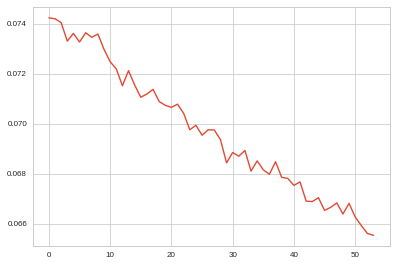

In [33]:
#@title ### Plot of Loss Values { form-width: "30%" }

compression = 10

loss = np.ndarray.flatten(loss_values)
loss = np.nanmean(np.pad(loss.astype(float), (0, compression - loss.size%compression), mode='constant', constant_values=np.NaN).reshape(-1, compression), axis=1)
plt.plot(loss)

In [ ]:
#@title ### Validation { form-width: "30%" }

pred_list = []
true_values = []
valid_loss=0
c=0
for databatch in tqdm(parsed_valid_dataset):

    target = databatch[1]
    true_values.append(target.numpy())

    predictions = model(databatch[0])
    pred_list.append(np.squeeze(predictions.numpy()))

    loss_value = tf.keras.losses.MeanSquaredError()(target,predictions).numpy()
    valid_loss+= loss_value
    c+=1

    print('validation loss', valid_loss/c)


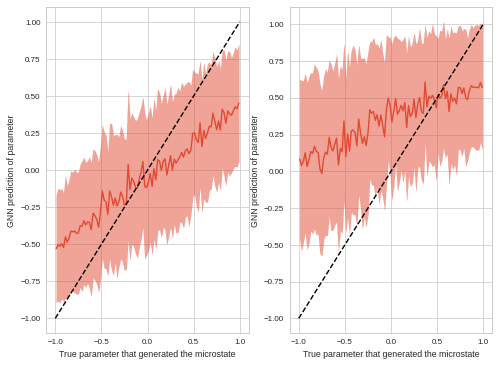

In [137]:
#@title ### Plots of Outputs

fig, axs = plt.subplots(1,2, figsize=(8, 6), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(2):
    pred_vals = np.array([pp[:,:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(true_vals.min(),true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')



#plt.savefig('gnn_' + str(run) + '.png',dpi=300)
#plt.show()

In [144]:
#@title ### Rollout Function { form-width: "30%" }

INPUT_SEQUENCE_LENGTH=WINDOW_SIZE-1

KINEMATIC_PARTICLE_ID = 3
def get_kinematic_mask(particle_types):
  """Returns a boolean mask, set to true for kinematic (obstacle) particles."""
  return tf.equal(particle_types, KINEMATIC_PARTICLE_ID)

def rollout(simulator, features, num_steps):
  """Rolls out a trajectory by applying the model in sequence."""
  
  initial_positions = features['pos'][tf.newaxis,0:INPUT_SEQUENCE_LENGTH]
  initial_velocities = features['vel'][tf.newaxis,0:INPUT_SEQUENCE_LENGTH]
  initial_accelerations = features['acc'][tf.newaxis,0:INPUT_SEQUENCE_LENGTH]
  ground_truth_positions = features['pos'][tf.newaxis,INPUT_SEQUENCE_LENGTH:]
  ground_truth_velocities = features['vel'][tf.newaxis,INPUT_SEQUENCE_LENGTH:]
  ground_truth_accelerations = features['acc'][tf.newaxis,INPUT_SEQUENCE_LENGTH:]
  global_context = None
  
  def step_fn(step, current_positions, current_velocities, current_accelerations, pos_predictions, vel_predictions, acc_predictions):
    if global_context is None:
      global_context_step = None
    else:
      global_context_step = global_context[
          step + INPUT_SEQUENCE_LENGTH - 1][tf.newaxis]

    next_velocity = simulator((current_positions,
                               current_velocities,
                               current_accelerations)
                    )
    next_position = next_velocity*dt+current_positions[:,-1]
    next_acceleration = (next_velocity - current_velocities[:,-1])/dt
    # Update kinematic particles from prescribed trajectory.
    kinematic_mask = get_kinematic_mask(tf.zeros(N))
    next_position_ground_truth = ground_truth_positions[:,step,:,:]
    next_velocity_ground_truth = ground_truth_velocities[:,step,:,:]
    next_acceleration_ground_truth = ground_truth_accelerations[:,step,:,:]
    next_position = tf.where(tf.expand_dims(kinematic_mask,-1), next_position_ground_truth,
                             next_position)
    next_velocity = tf.where(tf.expand_dims(kinematic_mask,-1), next_velocity_ground_truth,
                             next_velocity)
    next_acceleration = tf.where(tf.expand_dims(kinematic_mask,-1), next_acceleration_ground_truth,
                             next_acceleration)
    updated_pos_predictions = pos_predictions.write(step, next_position)
    updated_vel_predictions = vel_predictions.write(step, next_velocity)
    updated_acc_predictions = acc_predictions.write(step, next_acceleration)
    # Shift `current_positions`, removing the oldest position in the sequence
    # and appending the next position at the end.
    next_positions = tf.concat([current_positions[:,1:,:,:],
                                next_position[:,tf.newaxis,:,:]], axis=1)
    next_velocities = tf.concat([current_velocities[:,1:,:,:],
                                next_velocity[:,tf.newaxis,:,:]], axis=1)
    next_accelerations = tf.concat([current_accelerations[:,1:,:,:],
                                next_acceleration[:,tf.newaxis,:,:]], axis=1)
  
    return (step + 1, next_positions, next_velocities, next_accelerations, updated_pos_predictions, updated_vel_predictions, updated_acc_predictions)
  
  pos_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)
  vel_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)
  acc_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)

  _, _, _, _, pos_predictions, vel_predictions, acc_predictions = tf.while_loop(
      cond=lambda step, state, vel, acc, pos_prediction, vel_prediction, acc_prediction: tf.less(step, num_steps),
      body=step_fn,
      loop_vars=(0, initial_positions, initial_velocities, initial_accelerations, pos_predictions, vel_predictions, acc_predictions),
      parallel_iterations=1)
  
  #pos_predictions = tf.transpose(pos_predictions, perm=[1,0,2,3])

  output_dict = {
      'initial_positions': initial_positions,
      'initial_velocities': initial_velocities,
      'initial_accelerations': initial_accelerations,
      'pos_predicted_rollout': pos_predictions.stack(),
      'vel_predicted_rollout': vel_predictions.stack(),
      'acc_predicted_rollout': acc_predictions.stack(),
      'ground_truth_position_rollout': ground_truth_positions,
      'ground_truth_velocity_rollout': ground_truth_velocities,
      'ground_truth_acceleration_rollout': ground_truth_accelerations
  }

  
  for field in ['pos_predicted_rollout','vel_predicted_rollout','acc_predicted_rollout']:
    output_dict[field]=tf.transpose(output_dict[field], perm=[1,0,2,3])


  if global_context is not None:
    output_dict['global_context'] = global_context
  return output_dict

In [ ]:
#@title ### Create Rollout Data { form-width: "30%" }

valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_rollout_dataset = valid_dataset.map(_parse_record)
parsed_rollout_dataset = parsed_rollout_dataset.map(_parse_tensor)

for databatch in parsed_rollout_dataset:
    num_steps = databatch['pos'].shape[0]-INPUT_SEQUENCE_LENGTH
    output = rollout(model,databatch,num_steps)
    break

#output['metadata'] = metadata
filename = '/zonal_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(output, file)

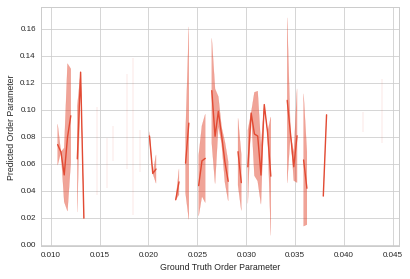

In [146]:
#@title ### Order Parameter Plot

pred_av_velocity = np.mean(output['vel_predicted_rollout'][0,...],axis=1)
true_av_velocity = np.mean(output['ground_truth_velocity_rollout'][0,...],axis=1)
pred_std = np.std(output['vel_predicted_rollout'][0,...],axis=1)
true_std = np.std(output['ground_truth_velocity_rollout'][0,...],axis=1)

pred_order_parameter = np.linalg.norm(pred_av_velocity,axis=1)/vs
true_order_parameter = np.linalg.norm(true_av_velocity,axis=1)/vs

line = np.linspace(0,max(pred_order_parameter),10)
#plt.scatter(true_order_parameter, pred_order_parameter)
#plt.plot(line, line)

order = np.argsort(true_order_parameter)
true_order_parameter = true_order_parameter[order]
pred_order_parameter = pred_order_parameter[order]

bin_means, bin_edges, binnumber = stats.binned_statistic(true_order_parameter, pred_order_parameter,bins=100)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

bin_stds, bin_edges, binnumber = stats.binned_statistic(true_order_parameter, pred_order_parameter,statistic='std',bins=100)

plt.plot(bin_centers,bin_means,c='C0')
plt.xlabel("Ground Truth Order Parameter")
plt.ylabel("Predicted Order Parameter")
plt.fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)


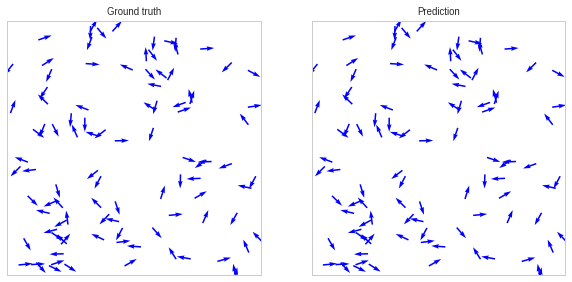

In [147]:
#@title ### Render Rollouts

TYPE_TO_COLOR = {
    3: "black",  # Boundary particles.
    0: "green",  # Rigid solids.
    7: "magenta",  # Goop.
    6: "gold",  # Sand.
    5: "blue",  # Water.
}

step_stride = 3
block_on_show = True

with open(filename, "rb") as file:
  rollout_data = pickle.load(file)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_info = []
Q={}
for ax_i, (label, (rollout_field_1, rollout_field_2)) in enumerate(
    [("Ground truth", ("ground_truth_position_rollout", "ground_truth_velocity_rollout")),
      ("Prediction", ("pos_predicted_rollout", "vel_predicted_rollout"))]):
  # Append the initial positions to get the full trajectory.
  pos_trajectory = np.concatenate([
      rollout_data["initial_positions"][0,...],
      rollout_data[rollout_field_1][0,...]], axis=0)
  vel_trajectory = np.concatenate([
      rollout_data["initial_velocities"][0,...],
      rollout_data[rollout_field_2][0,...]], axis=0)
  ax = axes[ax_i]
  ax.set_title(label)
  bounds = [(0,DOMAIN_SIZE), (0,DOMAIN_SIZE)]
  ax.set_xlim(bounds[0][0], bounds[0][1])
  ax.set_ylim(bounds[1][0], bounds[1][1])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect(1.)
  points = {
      particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
      for particle_type, color in TYPE_TO_COLOR.items()}
  X, Y, U, V = pos_trajectory[0,:,0], pos_trajectory[0,:,1], vel_trajectory[0,:,0], vel_trajectory[0,:,1]
  Q[f'{ax_i}'] = ax.quiver(X, Y, U, V, pivot='mid', color='b', units='inches')
  plot_info.append((ax, pos_trajectory, vel_trajectory, points))


num_steps = pos_trajectory.shape[0]
#print(pos_trajectory.shape)

def update_quiver(num):
  for i, (ax, pos_trajectory, vel_trajectory, _) in enumerate(plot_info):
    U, V = vel_trajectory[num,:,0], vel_trajectory[num,:,1]
    offsets = pos_trajectory[num]

    Q[f'{i}'].set_offsets(offsets)
    Q[f'{i}'].set_UVC(U,V)
  return axes

anim = animation.FuncAnimation(fig, update_quiver,
                               interval=50, frames=np.arange(0, num_steps, step_stride),blit=False)
#plt.show(block=block_on_show)
rc('animation', html='jshtml')
anim
